# Network Hydraulic Scaling Research Tools

The following scripts were created to develop the data used in Lapides et al. 2020. Funding for this work was provided by to Leclerc and Hahm by Simon Fraser University and a Natural Sciences and Engineering ResearchCouncil of Canada (NSERC) Undergraduate Student Research Award (USRA). Thank you to Margaret Zimmer for sharing streamflow data. 

All code, unless otherwise specified, is by Christine D Leclerc. 

## Import libraries

In [ ]:
from adjustText import adjust_text
import array
import fiona
import geopandas as gpd
import importlib.util
import io
from io import BytesIO
import math
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np
from osgeo import gdal
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import re
import requests
import scipy.optimize
from shapely.geometry import Point
import ulmo
import uncertainties
import urllib.request
from urllib.request import urlopen
import zipfile
from zipfile import ZipFile
plt.rcParams['font.sans-serif'] = 'Arial'

## Access watershed metadata

In [174]:
# Create data frame
dMeta = pd.read_csv('https://www.hydroshare.org/resource/37a7544cc3b944e88a8754bd6c1b8eb1/data/contents/ws_metadata.csv')

# Create arrays
areaM2 = []
areaFT2 = []
areaMI2 = []

# Populate arrays
for i in range(len(dMeta)):
    areaM2.append(areaKM2[i] * 1000000)   # m^2  = km^2 * 1000000
    areaFT2.append(areaKM2[i] * 1.076e7)  # ft^2 = km^2 * 1.076e+7
    areaMI2.append(areaKM2[i] * 0.386102) # mi^2 = km^2 * 0.386102

# Unit conversion foactors
CFSfromCMS   = 35.3146667 # ft^3/s = m^3/s * 35.3146667
CMSfromCFS   = 0.0283     # m^3/s  = ft^3/s * 0.0283
MMDAYfromFTS = 2.633e7    # mm/day = ft/s * 2.633e7
MMDAYfromMS  = 8.64e+7    # mm/day = m/s * 8.64e+7
CMSfromLS    = 0.001      # m^3/s  = L/s / 0.001
DAYfromS     = 86400      # day    = 86400 * s
KMfromMM     = 0.000001   # km     = mm * 0.000001
FT2fromkm2   = 1.076e+7   # ft^2   = km^2 * 1.076e+7
M2fromKM2    = 1000000    # m^2    = km^2 * 1000000
MMfromFT     = 304.8      # mm = ft * 304.8
MLSfromMLDAY = 1.1574074074074e-5  # ML/day * 1.1574074074074e-5
LSfromMLS    = 1000000    # L/s = ML/s * 1000000

## Process watershed discharge time series data

### Bull Creek

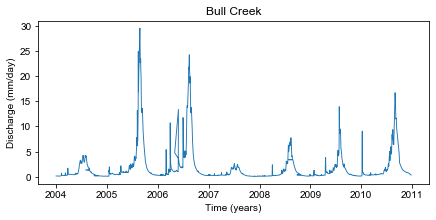

In [176]:
# Create data frames; Discharge units L/s
baseURL = 'https://www.hydroshare.org/resource/d6d8b2a6e5604629b1192233646dfea1/data/contents/WY'
dBull2004 = pd.read_csv(baseURL + '2004_gap_filled_Bull_discharge_daily.csv')
dBull2005 = pd.read_csv(baseURL + '2005_gap_filled_Bull_discharge_daily.csv')
dBull2006 = pd.read_csv(baseURL + '2006_gap_filled_Bull_discharge_daily.csv')
dBull2007 = pd.read_csv(baseURL + '2007_gap_filled_Bull_discharge_daily.csv')
dBull2008 = pd.read_csv(baseURL + '2008_gap_filled_Bull_discharge_daily.csv')
dBull2009 = pd.read_csv(baseURL + '2009_gap_filled_Bull_discharge_daily.csv')
dBull2010 = pd.read_csv(baseURL + '2010_gap_filled_Bull_discharge_daily.csv')

# Scrub data
# 2004
dBull2004.insert(0, 'date', '0')
dBull2004.insert(1, 'q_mm_per_day', '0')
dBull2004.rename(columns={dBull2004.columns[3]: 'Year', dBull2004.columns[4]: 'Month', dBull2004.columns[5]: 'Day'}, inplace=True)
dBull2004.rename(columns={dBull2004.columns[11]: 'B201', dBull2004.columns[12]: 'B203', dBull2004.columns[13]: 'B204'}, inplace=True)
dBull2004.drop(
    dBull2004.columns[[2, 6, 7, 8, 9, 10, 15, 16]], axis=1, inplace=True)

for i in dBull2004.index:  # Format data
    month = str(dBull2004['Month'][i])
    if len(str(dBull2004['Month'][i])) != 2:
        month = '0' + str(dBull2004['Month'][i])
    day = str(dBull2004['Day'][i])
    if len(str(dBull2004['Day'][i])) != 2:
        day = '0' + str(str(dBull2004['Day'][i]))
    date = str(dBull2004['Year'][i]) + '-' + month + '-' + day
    dBull2004.at[i, 'date'] = date
    q_mm_per_day = dBull2004['B201'][i] + \
        dBull2004['B203'][i] + dBull2004['B204'][i]
    dBull2004.at[i, 'q_mm_per_day'] = q_mm_per_day

for i in range(len(dBull2004)):  # Value scan
    dBull2004['date'].loc['2004-04-31'] = '2004-03-31'
    dBull2004['date'].loc['2004-06-31'] = '2004-05-31'
    dBull2004['date'].loc['2004-07-30'] = '2004-06-30'
    dBull2004['date'].loc['2004-09-31'] = '2004-08-31'

# Unit conversion
dBull2004['q_mm_per_day'] = dBull2004['q_mm_per_day'].astype(float)
dBull2004['q_mm_per_day'] = dBull2004['q_mm_per_day'] * CMSfromLS
dBull2004['q_mm_per_day'] = dBull2004['q_mm_per_day'] * CFSfromCMS
dBull2004['q_mm_per_day'] = dBull2004['q_mm_per_day'] / areaFT2[0]
dBull2004['q_mm_per_day'] = dBull2004['q_mm_per_day'] * MMDAYfromFTS
dBull2004.drop(dBull2004.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)
dBull2004.sort_values(by=['date'])
dBull2004 = dBull2004.reset_index(drop=True)

# 2005
dBull2005.insert(0, 'date', '0')
dBull2005.insert(1, 'q_mm_per_day', '0')
dBull2005.rename(columns={dBull2005.columns[3]: 'Year', dBull2005.columns[4]
                 : 'Month', dBull2005.columns[5]: 'Day'}, inplace=True)
dBull2005.rename(columns={dBull2005.columns[11]: 'B201', dBull2005.columns[12]
                 : 'B203', dBull2005.columns[13]: 'B204'}, inplace=True)
dBull2005.drop(
    dBull2005.columns[[2, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19]], axis=1, inplace=True)

for i in dBull2005.index:  # Format data
    month = str(dBull2005['Month'][i]).replace('.0', '')
    if len(str(dBull2005['Month'][i]).replace('.0', '')) != 2:
        month = '0' + str(dBull2005['Month'][i]).replace('.0', '')
    day = str(dBull2005['Day'][i]).replace('.0', '')
    if len(str(dBull2005['Day'][i]).replace('.0', '')) != 2:
        day = '0' + str(str(dBull2005['Day'][i])).replace('.0', '')
    date = str(dBull2005['Year'][i]).replace(
        '.0', '') + '-' + month.replace('.0', '') + '-' + day.replace('.0', '')
    dBull2005.at[i, 'date'] = date
    q_mm_per_day = dBull2005['B201'][i] + \
        dBull2005['B203'][i] + dBull2005['B204'][i]
    dBull2005.at[i, 'q_mm_per_day'] = q_mm_per_day

# Unit conversion
dBull2005['q_mm_per_day'] = dBull2005['q_mm_per_day'].astype(float)
dBull2005['q_mm_per_day'] = dBull2005['q_mm_per_day'] * CMSfromLS
dBull2005['q_mm_per_day'] = dBull2005['q_mm_per_day'] * CFSfromCMS
dBull2005['q_mm_per_day'] = dBull2005['q_mm_per_day'] / areaFT2[0]
dBull2005['q_mm_per_day'] = dBull2005['q_mm_per_day'] * MMDAYfromFTS
dBull2005.drop(dBull2005.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)
dBull2005 = dBull2005[0:365]
dBull2005.sort_values(by=['date'])
dBull2005 = dBull2005.reset_index(drop=True)

# 2006
dBull2006.insert(0, 'date', '0')
dBull2006.insert(1, 'q_mm_per_day', '0')
dBull2006.rename(columns={dBull2006.columns[3]: 'Year', dBull2006.columns[4]
                 : 'Month', dBull2006.columns[5]: 'Day'}, inplace=True)
dBull2006.rename(columns={dBull2006.columns[11]: 'B201', dBull2006.columns[12]
                 : 'B203', dBull2006.columns[13]: 'B204'}, inplace=True)
dBull2006.drop(
    dBull2006.columns[[2, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19]], axis=1, inplace=True)

for i in dBull2006.index:  # Format data
    month = str(dBull2006['Month'][i]).replace('.0', '')
    if len(str(dBull2006['Month'][i]).replace('.0', '')) != 2:
        month = '0' + str(dBull2006['Month'][i]).replace('.0', '')
    day = str(dBull2006['Day'][i]).replace('.0', '')
    if len(str(dBull2006['Day'][i]).replace('.0', '')) != 2:
        day = '0' + str(str(dBull2006['Day'][i])).replace('.0', '')
    date = str(dBull2006['Year'][i]).replace(
        '.0', '') + '-' + month.replace('.0', '') + '-' + day.replace('.0', '')
    dBull2006.at[i, 'date'] = date
    q_mm_per_day = dBull2006.B201[i] + dBull2006.B203[i] + dBull2006.B204[i]
    dBull2006.at[i, 'q_mm_per_day'] = q_mm_per_day

# Unit conversion
dBull2006['q_mm_per_day'] = dBull2006['q_mm_per_day'].astype(float)
dBull2006['q_mm_per_day'] = dBull2006['q_mm_per_day'] * CMSfromLS
dBull2006['q_mm_per_day'] = dBull2006['q_mm_per_day'] * CFSfromCMS
dBull2006['q_mm_per_day'] = dBull2006['q_mm_per_day'] / areaFT2[0]
dBull2006['q_mm_per_day'] = dBull2006['q_mm_per_day'] * MMDAYfromFTS
dBull2006.drop(dBull2006.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)
dBull2006 = dBull2006[0:365]
dBull2006.sort_values(by=['date'])
dBull2006 = dBull2006.reset_index(drop=True)

# 2007
dBull2007.insert(0, 'date', '0')
dBull2007.insert(1, 'q_mm_per_day', '0')
dBull2007.rename(columns={dBull2007.columns[3]: 'Year', dBull2007.columns[4]
                 : 'Month', dBull2007.columns[5]: 'Day'}, inplace=True)
dBull2007.rename(columns={dBull2007.columns[11]: 'B201', dBull2007.columns[12]
                 : 'B203', dBull2007.columns[13]: 'B204'}, inplace=True)
dBull2007.drop(
    dBull2007.columns[[2, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19]], axis=1, inplace=True)

# Format data
for i in dBull2007.index:
    month = str(dBull2007['Month'][i]).replace('.0', '')
    if len(str(dBull2007['Month'][i]).replace('.0', '')) != 2:
        month = '0' + str(dBull2007['Month'][i]).replace('.0', '')
    day = str(dBull2007['Day'][i]).replace('.0', '')
    if len(str(dBull2007['Day'][i]).replace('.0', '')) != 2:
        day = '0' + str(str(dBull2007['Day'][i])).replace('.0', '')
    date = str(dBull2007['Year'][i]).replace(
        '.0', '') + '-' + month.replace('.0', '') + '-' + day.replace('.0', '')
    dBull2007.at[i, 'date'] = date
    q_mm_per_day = dBull2007.B201[i] + dBull2007.B203[i] + dBull2007.B204[i]
    dBull2007.at[i, 'q_mm_per_day'] = q_mm_per_day

# Unit conversion
dBull2007['q_mm_per_day'] = dBull2007['q_mm_per_day'].astype(float)
dBull2007['q_mm_per_day'] = dBull2007['q_mm_per_day'] * CMSfromLS    
dBull2007['q_mm_per_day'] = dBull2007['q_mm_per_day'] * CFSfromCMS  
dBull2007['q_mm_per_day'] = dBull2007['q_mm_per_day'] / areaFT2[0]   
dBull2007['q_mm_per_day'] = dBull2007['q_mm_per_day'] * MMDAYfromFTS
dBull2007.drop(dBull2007.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)
dBull2007 = dBull2007[0:365]
dBull2007.sort_values(by=['date'])
dBull2007 = dBull2007.reset_index(drop=True)


# 2008
dBull2008.insert(0, 'date', '0')
dBull2008.insert(1, 'q_mm_per_day', '0')
dBull2008.rename(columns={dBull2008.columns[3]: 'Year', dBull2008.columns[4]: 'Month', dBull2008.columns[5]: 'Day'}, inplace=True)
dBull2008.rename(columns={dBull2008.columns[11]: 'B201', dBull2008.columns[12]: 'B203', dBull2008.columns[13]: 'B204'}, inplace=True)
dBull2008.drop(
    dBull2008.columns[[2, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19]], axis=1, inplace=True)

# Format data
for i in dBull2008.index:
    month = str(dBull2008['Month'][i]).replace('.0', '')
    if len(str(dBull2008['Month'][i]).replace('.0', '')) != 2:
        month = '0' + str(dBull2008['Month'][i]).replace('.0', '')
    day = str(dBull2008['Day'][i]).replace('.0', '')
    if len(str(dBull2008['Day'][i]).replace('.0', '')) != 2:
        day = '0' + str(str(dBull2008['Day'][i])).replace('.0', '')
    date = str(dBull2008['Year'][i]).replace(
        '.0', '') + '-' + month.replace('.0', '') + '-' + day.replace('.0', '')
    dBull2008.at[i, 'date'] = date
    q_mm_per_day = dBull2008['B201'][i] + \
        dBull2008['B203'][i] + dBull2008['B204'][i]
    dBull2008.at[i, 'q_mm_per_day'] = q_mm_per_day

for i in range(len(dBull2008)):  # Value scan
    dBull2008.date.loc['2008-04-31'] = '2008-03-31'
    dBull2008.date.loc['2008-06-31'] = '2008-05-31'
    dBull2008.date.loc['2008-09-31'] = '2008-08-31'

# Unit conversion
dBull2008['q_mm_per_day'] = dBull2008['q_mm_per_day'].astype(float)
dBull2008['q_mm_per_day'] = dBull2008['q_mm_per_day'] * CMSfromLS    
dBull2008['q_mm_per_day'] = dBull2008['q_mm_per_day'] * CFSfromCMS   
dBull2008['q_mm_per_day'] = dBull2008['q_mm_per_day'] / areaFT2[0]  
dBull2008['q_mm_per_day'] = dBull2008['q_mm_per_day'] * MMDAYfromFTS
dBull2008.drop(dBull2008.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)
dBull2008 = dBull2008[0:365]
dBull2008.sort_values(by=['date'])
dBull2008 = dBull2008.reset_index(drop=True)

# 2009
dBull2009.insert(0, 'date', '0')
dBull2009.insert(1, 'q_mm_per_day', '0')
dBull2009.rename(columns={dBull2009.columns[3]: 'Year', dBull2009.columns[4]: 'Month', dBull2009.columns[5]: 'Day'}, inplace=True)
dBull2009.rename(columns={dBull2009.columns[11]: 'B201', dBull2009.columns[14]: 'B203', dBull2009.columns[17]: 'B204'}, inplace=True)
dBull2009.drop(dBull2009.columns[[
               2, 6, 7, 8, 9, 10, 12, 13, 15, 16, 18, 19, 21, 22]], axis=1, inplace=True)

# Format data
for i in dBull2009.index:
    month = str(dBull2009['Month'][i])
    if len(str(dBull2009['Month'][i])) != 2:
        month = '0' + str(dBull2009['Month'][i])
    day = str(dBull2009['Day'][i])
    if len(str(dBull2009['Day'][i])) != 2:
        day = '0' + str(str(dBull2009['Day'][i]))
    date = str(dBull2009['Year'][i]) + '-' + month + '-' + day
    dBull2009.at[i, 'date'] = date
    q_mm_per_day = dBull2009.B201[i] + dBull2009.B203[i] + dBull2009.B204[i]
    dBull2009.at[i, 'q_mm_per_day'] = q_mm_per_day

# Unit conversion
dBull2009['q_mm_per_day'] = dBull2009['q_mm_per_day'].astype(float)
dBull2009['q_mm_per_day'] = dBull2009['q_mm_per_day'] * CMSfromLS    
dBull2009['q_mm_per_day'] = dBull2009['q_mm_per_day'] * CFSfromCMS   
dBull2009['q_mm_per_day'] = dBull2009['q_mm_per_day'] / areaFT2[0]   
dBull2009['q_mm_per_day'] = dBull2009['q_mm_per_day'] * MMDAYfromFTS
dBull2009.drop(dBull2009.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)
dBull2009 = dBull2009[0:365]
dBull2009.sort_values(by=['date'])
dBull2009 = dBull2009.reset_index(drop=True)


# 2010
dBull2010.insert(0, 'date', '0')
dBull2010.insert(1, 'q_mm_per_day', '0')
dBull2010.rename(columns={dBull2010.columns[3]: 'Year', dBull2010.columns[4]: 'Month', dBull2010.columns[5]: 'Day'}, inplace=True)
dBull2010.rename(columns={dBull2010.columns[11]: 'B201', dBull2010.columns[14]: 'B203', dBull2010.columns[17]: 'B204'}, inplace=True)
dBull2010.drop(dBull2010.columns[[
               2, 6, 7, 8, 9, 10, 12, 13, 15, 16, 18, 19, 21, 22]], axis=1, inplace=True)

# Format data
for i in dBull2010.index:
    month = str(dBull2010['Month'][i])
    if len(str(dBull2010['Month'][i])) != 2:
        month = '0' + str(dBull2010['Month'][i])
    day = str(dBull2010['Day'][i])
    if len(str(dBull2010['Day'][i])) != 2:
        day = '0' + str(str(dBull2010['Day'][i]))
    date = str(dBull2010['Year'][i]) + '-' + month + '-' + day
    dBull2010.at[i, 'date'] = date
    q_mm_per_day = dBull2010['B201'][i] + \
        dBull2010['B203'][i] + dBull2010['B204'][i]
    dBull2010.at[i, 'q_mm_per_day'] = q_mm_per_day

# Unit conversion
dBull2010['q_mm_per_day'] = dBull2010['q_mm_per_day'].astype(float)
dBull2010['q_mm_per_day'] = dBull2010['q_mm_per_day'] * CMSfromLS 
dBull2010['q_mm_per_day'] = dBull2010['q_mm_per_day'] * CFSfromCMS
dBull2010['q_mm_per_day'] = dBull2010['q_mm_per_day'] / areaFT2[0] 
dBull2010['q_mm_per_day'] = dBull2010['q_mm_per_day'] * MMDAYfromFTS
dBull2010.drop(dBull2010.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)
dBull2010.sort_values(by=['date'])
dBull2010 = dBull2010.reset_index(drop=True)

# Concatenate data frames for 2004 to 2010
dBull = pd.concat([dBull2004, dBull2005, dBull2006, dBull2007,
                   dBull2008, dBull2009, dBull2010], axis=0)
dBull.q_mm_per_day = round(dBull.q_mm_per_day, 3)
dBull.sort_values(by=['date'])
dBull = dBull.reset_index(drop=True)

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(dBull['date'], dBull['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='Bull Creek')
labels = ['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011']
ticks_to_use = dBull.index[::365]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)
plt.show()

### Caspar Creek

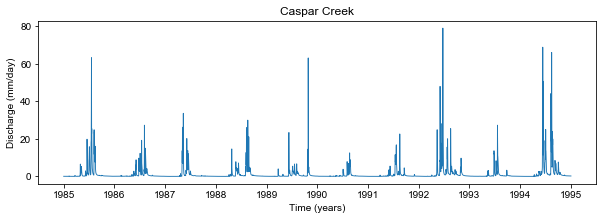

In [177]:
# Create data frames
dCasparN = pd.read_csv('https://www.fs.fed.us/psw/topics/water/caspar/data/flow/daily/tribs/nflo8695.txt.gz',
                       compression='gzip', header=None, sep=',', quotechar='"')  # Discharge in cfs
dCasparN.insert(0, 'date', '')
dCasparN.insert(1, 'q_mm_per_day', '')
dCasparS = pd.read_csv('https://www.fs.fed.us/psw/topics/water/caspar/data/flow/daily/tribs/sflo8695.txt.gz',
                       compression='gzip', header=None, sep=',', quotechar='"')  # Discharge in cfs
dCasparS.insert(0, 'date', '')
dCasparS.insert(1, 'q_mm_per_day', '')

# Scrub data
# Format data for north tributary
dCasparN.rename(columns={0: 'originaldata'}, inplace=True)
for i in dCasparN.index:
    year = dCasparN['originaldata'][i][6:8]
    if year >= str(85):
        year = '19' + year
    month = dCasparN['originaldata'][i][:2]
    day = dCasparN['originaldata'][i][3:5]
    date = year + '-' + month + '-' + day
    dCasparN.at[i, 'date'] = date
    q = dCasparN['originaldata'][i][15:23]
    dCasparN.at[i, 'q_mm_per_day'] = q

dCasparN.drop(dCasparN.columns[[2]], axis=1, inplace=True)

dCasparS.rename(columns={0: 'originaldata'}, inplace=True)

# Format data for south tributary
for i in dCasparS.index:
    year = dCasparS['originaldata'][i][6:8]
    if year >= str(85):
        year = '19' + year
    month = dCasparS['originaldata'][i][:2]
    day = dCasparS['originaldata'][i][3:5]
    date = year + '-' + month + '-' + day
    dCasparS.at[i, 'date'] = date
    q = dCasparS['originaldata'][i][15:23]
    dCasparS.at[i, 'q_mm_per_day'] = q

dCasparS.drop(dCasparS.columns[[2]], axis=1, inplace=True)

# Merge data from north and south tributaries
dCaspar = pd.merge(left=dCasparN, left_on='date',
                   right=dCasparS, right_on='date')
dCaspar.insert(1, 'q_mm_per_day', '')

for i in dCaspar.index:
    q = float(dCaspar['q_mm_per_day_x'][i]) + float(dCaspar['q_mm_per_day_y'][i])
    dCaspar.at[i, 'q_mm_per_day'] = q

dCaspar.drop(dCaspar.columns[[2, 3]], axis=1, inplace=True)

# Unit conversion
dCaspar['q_mm_per_day'] = dCaspar['q_mm_per_day'] / areaFT2[1]
dCaspar['q_mm_per_day'] = dCaspar['q_mm_per_day'] * MMDAYfromFTS
dCaspar['q_mm_per_day'] = pd.to_numeric(dCaspar['q_mm_per_day'])
dCaspar['q_mm_per_day'] = round(dCaspar['q_mm_per_day'], 3)
dCaspar = dCaspar.sort_values(by=['date'])
dCaspar = dCaspar.reset_index(drop=True)

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(dCaspar['date'], dCaspar['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='Caspar Creek')
labels = ['1985', '1986', '1987', '1988', '1989', '1990',
          '1991', '1992', '1993', '1994', '1995', '1996']
ticks_to_use = dCaspar.index[::365]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)
plt.show()

### CWT12

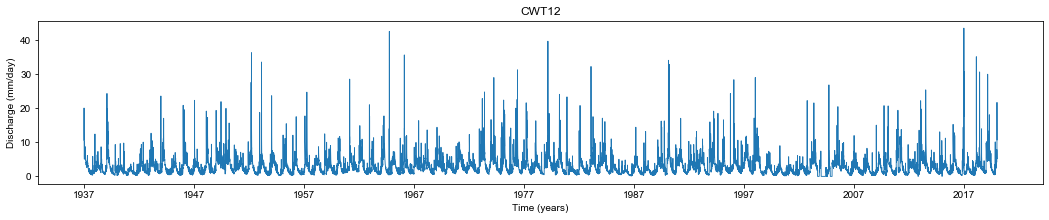

In [178]:
# Create data frame
z = urlopen(
    'https://www.fs.usda.gov/rds/archive/products/RDS-2016-0025/RDS-2016-0025.zip')
myzip = ZipFile(BytesIO(z.read())).extract(
    'Data/ws18_daily_flow_1937_2019.csv')
dCWT12 = pd.read_csv(myzip)

# Scrub data
dCWT12.rename(columns={'CSM': 'q_mm_per_day'}, inplace=True)
dCWT12.insert(3, 'date', date)

# Format data
for i in range(len(dCWT12)):
    waterYear = str(dCWT12['WYR'].iloc[i])
    month = str(dCWT12['MO'].iloc[i])
    day = str(dCWT12['DAY'].iloc[i])
    if len(month) != 2:  # Check MM format
        month = '0' + month
    if len(day) != 2:   # Check DD format
        day = '0' + day
    date = waterYear + '-' + month + '-' + day  # ISO format
    dCWT12.at[i, 'date'] = date
    if dCWT12['q_mm_per_day'].iloc[i] == '.':
        discharge = 0
    else:
        discharge = dCWT12['q_mm_per_day'].iloc[i]
    dCWT12.at[i, 'q_mm_per_day'] = discharge

# Unit conversion
dCWT12['q_mm_per_day'] = dCWT12['q_mm_per_day'].astype(float)
dCWT12['q_mm_per_day'] = dCWT12['q_mm_per_day'] * areaMI2[2]
dCWT12['q_mm_per_day'] = dCWT12['q_mm_per_day'] / areaFT2[2]
dCWT12['q_mm_per_day'] = dCWT12['q_mm_per_day'] * MMDAYfromFTS
dCWT12 = dCWT12.drop(columns=['WYR', 'MO', 'DAY'])
dCWT12['q_mm_per_day'] = round(dCWT12['q_mm_per_day'], 3)
dCWT12 = dCWT12.sort_values(by=['date'])
dCWT12 = dCWT12.reset_index(drop=True)

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(18, 3))
ax.plot(dCWT12['date'], dCWT12['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='CWT12')
labels = ['1937', '1947', '1957', '1967',
          '1977', '1987', '1997', '2007', '2017']
ticks_to_use = dCWT12.index[::3650]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)
plt.show()

### Duke Forest

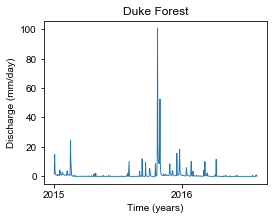

In [179]:
# Create data frame based on processed data (original data available by request)

dDuke = pd.read_csv(
    'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_dukeforest.csv', index_col=0)

### Start code used to transform original data ###

# Create data frames
#fullQuery = 'zip/duke_WSA_WS1_mmhr_sync_5Dec16.csv'
# dDuke = pd.read_csv(fullQuery)  # Discharge in mm/hr

# Scrub data
#dDuke.insert(0, 'date', '0')
#dDuke.insert(1, 'q_mm_per_day', '0')
#dDuke.rename(columns={dDuke.columns[2]: 'timestamp', dDuke.columns[3]: 'WSA', dDuke.columns[4]: 'WS1'}, inplace=True)
#dDuke.drop(dDuke.columns[[5, 6]], axis=1, inplace=True)

# for i in dDuke.index:
#    q_mm_per_day = dDuke.WS1[i]  # Use WS 1 data
#    dDuke.at[i, 'q_mm_per_day'] = q_mm_per_day
#    timestamp = str(dDuke.timestamp[i])
#    timestamp = timestamp[0:10]
#    dDuke.at[i, 'date'] = timestamp

# Unit conversion
#dDuke.drop(dDuke.columns[[2, 3, 4]], axis=1, inplace=True)
# dDuke['q_mm_per_day'] = dDuke['q_mm_per_day'] * 24  # Multiply discharge in mm/hr by 24 to get mm/day
# dDuke = dDuke.groupby('date')['q_mm_per_day'].mean() # Find average daily discharge
#dDuke = dDuke.to_string().split('\n')
#dDuke = dDuke[1:]
#date = list()
#q_mm_per_day = list()

# for line in dDuke:
#    date.append(line[:10])
#    q_mm_per_day.append(line[14:])

#qTimeseries = {'date': date, 'q_mm_per_day': q_mm_per_day}
#dDuke = pd.DataFrame(qTimeseries, columns=['date', 'q_mm_per_day'])
#dDuke['q_mm_per_day'] = dDukeforest['q_mm_per_day'].astype(float)
#dDuke['q_mm_per_day'] = round(dDukeforest['q_mm_per_day'], 3)
# dDuke.sort_values(by=['date'])

### End code used to transform original data ###

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(dDuke['date'], dDuke['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='Duke Forest')
labels = ['2015', '2016', '2017']
ticks_to_use = dDuke.index[::365]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)
plt.show()

### Elder Creek

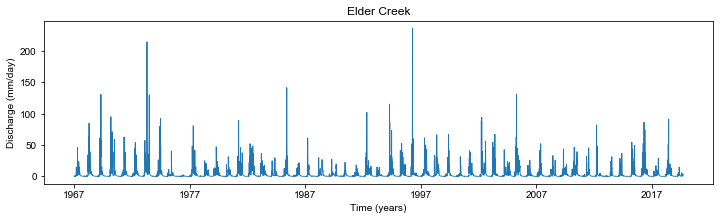

In [180]:
# Create data frame
dElder = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=11475560&referred_module=sw&period=&begin_date=' +
                     start[4] + '&end_date=' + stop[4], header=31, delim_whitespace=True)  # Discharge in cfs

# Scrub data
dElder.columns = ['usgs', 'site', 'date', 'q_mm_per_day', 'a']
dElder = dElder.drop(columns=['usgs', 'site', 'a'])

# Unit conversion
dElder['q_mm_per_day'] = dElder['q_mm_per_day'] / areaFT2[4]
dElder['q_mm_per_day'] = dElder['q_mm_per_day'] * MMDAYfromFTS
dElder['q_mm_per_day'] = round(dElder['q_mm_per_day'], 3)
dElder.sort_values(by=['date'])

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(dElder['date'], dElder['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='Elder Creek')
labels = ['1967', '1977', '1987', '1997', '2007', '2017']
ticks_to_use = dElder.index[::3650]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)
plt.show()

### FNW37

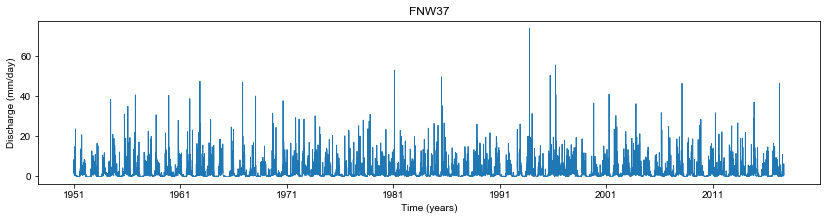

In [181]:
# Create data frame
z = urlopen(
    'https://www.fs.usda.gov/rds/archive/products/RDS-2011-0015/RDS-2011-0015.zip')
myzip = ZipFile(BytesIO(z.read())).extract('Data/Fernow_Streamflow.csv')
dFNW37 = pd.read_csv(myzip)  # Discharge in mm/day

# Scrub data
dFNW37.rename(columns={'Date (mm/dd/yyyy)': 'date',
                       'Discharge (mm)': 'q_mm_per_day'}, inplace=True)
dFNW37 = dFNW37[92443:116793]  # Get WS 4 records

# Format data
for i in dFNW37.index:
    waterYear = str()
    waterYear = str(dFNW37['date'][i])
    waterYear = re.findall('/(\d\d\d\d)', waterYear)
    waterYear = ''.join(waterYear)
    month = str()
    month = dFNW37['date'][i]
    month = re.findall('(\d+)/\d+/\d\d\d\d', month)
    month = ''.join(month)
    day = str()
    day = dFNW37['date'][i]
    day = re.findall('\d+/(\d+)/\d\d\d\d', day)
    day = ''.join(day)
    if len(month) != 2:
        month = '0' + month
    if len(day) != 2:
        day = '0' + day
    date = waterYear + '-' + month + '-' + day
    dFNW37.at[i, 'date'] = date

dFNW37 = dFNW37.drop(columns=['Watershed'])
dFNW37 = dFNW37.sort_values(by=['date'])

# Get average daily discharge
dFNW37 = dFNW37.groupby('date')['q_mm_per_day'].mean()
dFNW37 = dFNW37.to_string().replace('date', '').split('\n')
dFNW37 = dFNW37[1:]
dateList = [i.split(' ')[0] for i in dFNW37]
qList = [i.split(' ', 1)[1] for i in dFNW37]

# Re-create data frame
dFNW37 = pd.DataFrame(list(zip(dateList, qList)),
                      columns=['date', 'q_mm_per_day'])
dFNW37['q_mm_per_day'] = pd.to_numeric(dFNW37['q_mm_per_day'])
dFNW37['q_mm_per_day'] = round(dFNW37['q_mm_per_day'], 3)
dFNW37.sort_values(by=['date'])
dFNW37 = dFNW37.reset_index(drop=True)

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(dFNW37['date'], dFNW37['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='FNW37')
labels = ['1951', '1961', '1971', '1981', '1991', '2001', '2011']
ticks_to_use = dFNW37.index[::3650]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)
plt.show()

### HB13

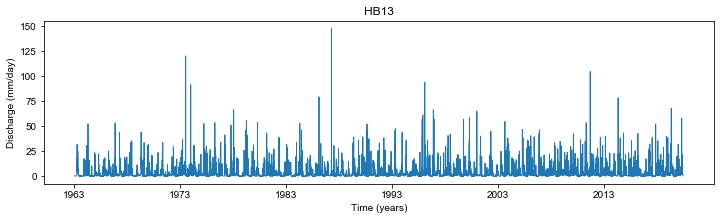

In [182]:
# Create data frame; Discharge in mm/day
dHB13 = pd.read_csv(
    'https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-hbr.2.11&entityid=1254d17cbd381556c05afa740d380e78')

# Scrub data
dHB13.rename(columns={'DATE': 'date', 'WS': 'watershed',
                      'Streamflow': 'q_mm_per_day'}, inplace=True)
dHB13 = dHB13.drop(columns=['Flag'])
dHB13['q_mm_per_day'] = pd.to_numeric(dHB13['q_mm_per_day'])
dHB13 = dHB13.loc[dHB13['watershed'] == 6]  # Get WS 6 records
dHB13 = dHB13.drop(columns=['watershed'])
dHB13['q_mm_per_day'] = round(dHB13['q_mm_per_day'], 3)
dHB13.sort_values(by=['date'])
dHB13 = dHB13.reset_index(drop=True)

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(dHB13['date'], dHB13['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='HB13')
labels = ['1963', '1973', '1983', '1993', '2003', '2013']
ticks_to_use = dHB13.index[::3650]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)
plt.show()

### HB42

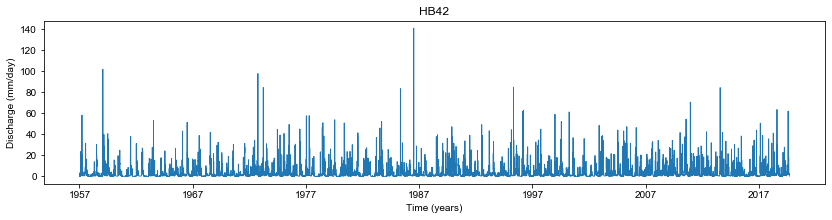

In [183]:
# Create data frame; Discharge in mm/day
dHB42 = pd.read_csv(
    'https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-hbr.2.11&entityid=1254d17cbd381556c05afa740d380e78')

# Scrub data
dHB42.rename(columns={'DATE': 'date', 'WS': 'watershed',
                      'Streamflow': 'q_mm_per_day'}, inplace=True)
dHB42 = dHB42.drop(columns=['Flag'])
dHB42['q_mm_per_day'] = pd.to_numeric(dHB42['q_mm_per_day'])
dHB42 = dHB42.loc[dHB42['watershed'] == 3]  # Get WS 3 records
dHB42 = dHB42.drop(columns=['watershed'])
dHB42['q_mm_per_day'] = round(dHB42['q_mm_per_day'], 3)
dHB42.sort_values(by=['date'])
dHB42 = dHB42.reset_index(drop=True)

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(dHB42['date'], dHB42['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='HB42')
labels = ['1957', '1967', '1977', '1987', '1997', '2007', '2017']
ticks_to_use = dHB42.index[::3650]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)
plt.show()

### Pioneer Creek
Based on code by W Jesse Hahm

processing data from request: https://nwis.waterservices.usgs.gov/nwis/iv/?format=waterml&site=13306336&startDT=2011-11-05T00%3A00%3A00&endDT=2020-05-29T00%3A00%3A00
processing data from request: https://nwis.waterservices.usgs.gov/nwis/iv/?format=waterml&site=13310850&startDT=2011-11-05T00%3A00%3A00&endDT=2020-05-29T00%3A00%3A00
processing data from request: https://nwis.waterservices.usgs.gov/nwis/iv/?format=waterml&site=13313000&startDT=2011-11-05T00%3A00%3A00&endDT=2020-05-29T00%3A00%3A00
processing data from request: https://nwis.waterservices.usgs.gov/nwis/iv/?format=waterml&site=13310199&startDT=2011-11-05T00%3A00%3A00&endDT=2020-05-29T00%3A00%3A00
processing data from request: https://nwis.waterservices.usgs.gov/nwis/iv/?format=waterml&site=13297330&startDT=2011-11-05T00%3A00%3A00&endDT=2020-05-29T00%3A00%3A00


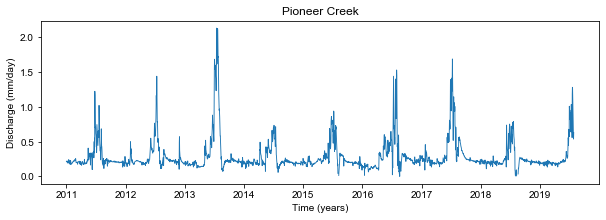

In [184]:
# Create dictionaries to re-construct discharge for Pioneer Creek
# per Whiting and Godsey 2016
name_id = {
    'Blackbird Ck.': 13306336,
    'Meadow Ck.': 13310850,
    'Johnson Ck.': 13313000,
    'Middle Fork Salmon': 13310199,
    'Thompson Ck.': 13297330,
}

a = 0.016  # Pre-factor per Whiting and Godsey 2016, eq. (3)

# Correction factors for discharge per Whiting and Godsey 2016
name_coef = {
    'Blackbird Ck.': 0.054,
    'Meadow Ck.': -0.174,
    'Johnson Ck.': 0.003,
    'Middle Fork Salmon': 0.001,
    'Thompson Ck.': -0.094,
}

# Function to get data


def getUSGSdata(siteno, startdate, enddate):
    sitename = {}
    sitename = ulmo.usgs.nwis.get_site_data(
        siteno, service='iv', start=startdate, end=enddate, methods='all')
    sitename = pd.DataFrame(sitename)
    sitename = pd.DataFrame(sitename['00060:00000']['values'])
    sitename['date'] = pd.to_datetime(
        pd.Series(sitename['datetime']), utc=True).dt.tz_convert('US/Pacific')
    sitename.set_index(['date'], inplace=True)
    dPio = sitename.value.astype(float)
    dPio = dPio.resample('15min').mean()
    return dPio


# Convert discharge in cfs to cms
dPios = []
for value in name_id.values():
    site = str(value)
    startdate = pd.to_datetime('2011-11-05')
    enddate = pd.to_datetime('2020-05-29')
    series = getUSGSdata(site, startdate, enddate)
    dPio = pd.DataFrame()
    dPio['CFS'] = series
    dPio['CMS'] = dPio['CFS'] / 35.3146662126613
    dPios.append(dPio)

# Run interpolate function on datasets used to reconstruct Pioneer Creek discharge
interps = []
for dPio in dPios:
    interps.append(dPio.interpolate())

# Create gap-filled datasets and use correction factors per Whiting and Godsey 2016
correcteds = []
for i, dPio in enumerate(interps):
    corrected = dPio * list(name_coef.values())[i]
    correcteds.append(corrected)

# Add corrected values per Whiting and Godsey 2016, eq. (3)
final = a + correcteds[0] + correcteds[1] + \
    correcteds[2] + correcteds[3] + correcteds[4]
final = final[final > 0]

# Plot reconstructed Pioneer Creek discharge time series in  mm/day
final['mm15min'] = final['CMS'] * 1000 * 60 * 15 / (15.8 * 10 ** 6)
final['q_mm_per_day'] = final['mm15min'] * 4 * 24
final_daily = final['q_mm_per_day'].resample('1D').mean()
final_daliy = final_daily.iloc[1:]

# Finalize data
final_daily_date = list()
final_daily_q = list()

# Format data
for i in range(len(final_daily)):
    dateStr = str(final_daily.index[i])
    dateStr = dateStr[0:10]
    final_daily_date.append(dateStr)
    final_daily_q.append(final_daily[i])

d = {'date': final_daily_date, 'q_mm_per_day': final_daily_q}
dPioDaily = pd.DataFrame(data=d)

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(dPioDaily['date'], dPioDaily['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='Pioneer Creek')
labels = ['2011', '2012', '2013', '2014', '2015',
          '2016', '2017', '2018', '2019', '2020']
ticks_to_use = dPioDaily.index[::365]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)
plt.show()

### Providence Creek

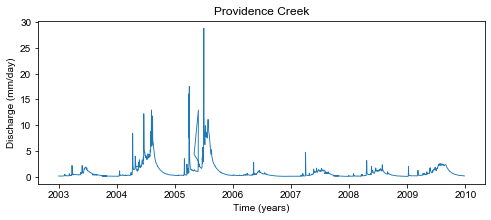

In [185]:
# Create data frames; Discharge in L/s
baseURL = 'https://sndl.ucmerced.edu/files/MHWG/Field/Southern_Sierra_CZO_KREW/Providence_Creek/Discharge/Level_1b/WY'
dProv2004 = pd.read_csv(
    baseURL + '2004_gap_filled_Providence_discharge_daily.csv', low_memory=False)
dProv2005 = pd.read_csv(
    baseURL + '2005_gap_filled_Providence_discharge_daily.csv', low_memory=False)
dProv2006 = pd.read_csv(
    baseURL + '2006_gap_filled_Providence_discharge_daily.csv', low_memory=False)
dProv2007 = pd.read_csv(
    baseURL + '2007_gap_filled_Providence_discharge_daily.csv', low_memory=False)
dProv2008 = pd.read_csv(
    baseURL + '2008_gap_filled_Providence_discharge_daily.csv', low_memory=False)
dProv2009 = pd.read_csv(
    baseURL + '2009_gap_filled_Providence_discharge_daily.csv', low_memory=False)
dProv2010 = pd.read_csv(
    baseURL + '2010_gap_filled_Providence_discharge_daily.csv', low_memory=False)

# Scrub data
# 2004
dProv2004.insert(0, 'date', '0')
dProv2004.insert(1, 'q_mm_per_day', '0')
dProv2004.rename(columns={dProv2004.columns[3]: 'Year', dProv2004.columns[4]                          : 'Month', dProv2004.columns[5]: 'Day'}, inplace=True)
dProv2004.rename(columns={dProv2004.columns[11]: 'P301', dProv2004.columns[12]: 'P303',
                          dProv2004.columns[13]: 'P304', dProv2004.columns[14]: 'D102'}, inplace=True)
dProv2004.drop(dProv2004.columns[[2, 6, 7, 8, 9, 10]], axis=1, inplace=True)

# Format data
for i in dProv2004.index:
    month = str(dProv2004['Month'][i])
    if len(str(dProv2004['Month'][i])) != 2:
        month = '0' + str(dProv2004['Month'][i])
    day = str(dProv2004['Day'][i])
    if len(str(dProv2004['Day'][i])) != 2:
        day = '0' + str(dProv2004['Day'][i])
    date = str(dProv2004['Year'][i]) + '-' + month + '-' + day
    dProv2004.at[i, 'date'] = date
    q_mm_per_day = float(dProv2004.P301[i]) + float(dProv2004.P303[i]) + float(
        dProv2004.P304[i]) + float(dProv2004.D102[i])
    dProv2004.at[i, 'q_mm_per_day'] = q_mm_per_day

# Value scan
for i in range(len(dProv2004)):
    dProv2004['date'].loc['2004-04-31'] = '2004-03-31'
    dProv2004['date'].loc['2004-05-30'] = '2004-04-30'
    dProv2004['date'].loc['2004-06-31'] = '2004-05-31'
    dProv2004['date'].loc['2004-07-30'] = '2004-06-30'
    dProv2004['date'].loc['2004-08-31'] = '2004-07-31'
    dProv2004['date'].loc['2004-09-31'] = '2004-08-31'

# Unit conversion
dProv2004['q_mm_per_day'] = dProv2004['q_mm_per_day'].astype(float)
dProv2004['q_mm_per_day'] = dProv2004['q_mm_per_day'] * CMSfromLS 
dProv2004['q_mm_per_day'] = dProv2004['q_mm_per_day'] * CFSfromCMS
dProv2004['q_mm_per_day'] = dProv2004['q_mm_per_day'] / areaFT2[9]
dProv2004['q_mm_per_day'] = dProv2004['q_mm_per_day'] * MMDAYfromFTS
dProv2004.drop(dProv2004.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)

# 2005
dProv2005.insert(0, 'date', '0')
dProv2005.insert(1, 'q_mm_per_day', '0')
dProv2005.rename(columns={dProv2005.columns[3]: 'Year', dProv2005.columns[4]
                 : 'Month', dProv2005.columns[5]: 'Day'}, inplace=True)
dProv2005.rename(columns={dProv2005.columns[11]: 'P301', dProv2005.columns[12]: 'P303',
                          dProv2005.columns[13]: 'P304', dProv2005.columns[14]: 'D102'}, inplace=True)
dProv2005.drop(
    dProv2005.columns[[2, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19]], axis=1, inplace=True)
dProv2005 = dProv2005[0:365]

# Format data
for i in dProv2005.index:
    month = str(dProv2005['Month'][i]).replace('.0', '')
    if len(month) != 2:
        month = '0' + str(dProv2005['Month'][i])
    day = str(dProv2005['Day'][i]).replace('.0', '')
    if len(day) != 2:
        day = '0' + str(dProv2005['Day'][i])
    date = str(dProv2005['Year'][i]).replace(
        '.0', '') + '-' + month.replace('.0', '') + '-' + day.replace('.0', '')
    dProv2005.at[i, 'date'] = date

# Add subwatershed values
for i in dProv2005.index:
    q_mm_per_day = dProv2005.P301[i] + dProv2005.P303[i] + \
        dProv2005.P304[i] + dProv2005.D102[i]
    dProv2005.at[i, 'q_mm_per_day'] = q_mm_per_day

# Unit conversion
dProv2005['q_mm_per_day'] = dProv2005['q_mm_per_day'].astype(float)
dProv2005.drop(dProv2005.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)
dProv2005['q_mm_per_day'] = dProv2005['q_mm_per_day'] * CMSfromLS   
dProv2005['q_mm_per_day'] = dProv2005['q_mm_per_day'] * CFSfromCMS
dProv2005['q_mm_per_day'] = dProv2005['q_mm_per_day'] / areaFT2[9]
dProv2005['q_mm_per_day'] = dProv2005['q_mm_per_day'] * MMDAYfromFTS

# 2006
dProv2006.insert(0, 'date', '0')
dProv2006.insert(1, 'q_mm_per_day', '0')
dProv2006.rename(columns={dProv2006.columns[3]: 'Year', dProv2006.columns[4]: 'Month', dProv2006.columns[5]: 'Day'}, inplace=True)
dProv2006.rename(columns={dProv2006.columns[11]: 'P301', dProv2006.columns[12]: 'P303',
                          dProv2006.columns[13]: 'P304', dProv2006.columns[14]: 'D102'}, inplace=True)
dProv2006.drop(
    dProv2006.columns[[2, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19]], axis=1, inplace=True)
dProv2006 = dProv2006[0:365]

# Format data
for i in dProv2006.index:
    month = str(dProv2006['Month'][i]).replace('.0', '')
    if len(month) != 2:
        month = '0' + str(dProv2006['Month'][i])
    day = str(dProv2006['Day'][i]).replace('.0', '')
    if len(day) != 2:
        day = '0' + str(dProv2006['Day'][i])
    date = str(dProv2006.Year[i]).replace(
        '.0', '') + '-' + month.replace('.0', '') + '-' + day.replace('.0', '')
    dProv2006.at[i, 'date'] = date

# Add subwatershed values
for i in dProv2006.index:
    q_mm_per_day = dProv2006.P301[i] + dProv2006.P303[i] + \
        dProv2006.P304[i] + dProv2006.D102[i]
    dProv2006.at[i, 'q_mm_per_day'] = q_mm_per_day

dProv2006.drop(dProv2006.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)

# Unit conversion
dProv2006['q_mm_per_day'] = dProv2006['q_mm_per_day'].astype(float)
dProv2006['q_mm_per_day'] = dProv2006['q_mm_per_day'] * CMSfromLS
dProv2006['q_mm_per_day'] = dProv2006['q_mm_per_day'] * CFSfromCMS
dProv2006['q_mm_per_day'] = dProv2006['q_mm_per_day'] / areaFT2[9] 
dProv2006['q_mm_per_day'] = dProv2006['q_mm_per_day'] * MMDAYfromFTS

# 2007
dProv2007.insert(0, 'date', '0')
dProv2007.insert(1, 'q_mm_per_day', '0')
dProv2007.rename(columns={dProv2007.columns[3]: 'Year', dProv2007.columns[4]: 'Month', dProv2007.columns[5]: 'Day'}, inplace=True)
dProv2007.rename(columns={dProv2007.columns[11]: 'P301', dProv2007.columns[12]: 'P303',
                          dProv2007.columns[13]: 'P304', dProv2007.columns[14]: 'D102'}, inplace=True)
dProv2007.drop(
    dProv2007.columns[[2, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19]], axis=1, inplace=True)

# Format data
dProv2007 = dProv2007[0:365]
for i in dProv2007.index:
    month = str(dProv2007['Month'][i]).replace('.0', '')
    if len(month) != 2:
        month = '0' + str(dProv2007['Month'][i])
    day = str(dProv2007['Day'][i]).replace('.0', '')
    if len(day) != 2:
        day = '0' + str(dProv2007['Day'][i])
    date = str(dProv2007['Year'][i]).replace(
        '.0', '') + '-' + month.replace('.0', '') + '-' + day.replace('.0', '')
    dProv2007.at[i, 'date'] = date

# Add subwatershed values
for i in dProv2007.index:
    q_mm_per_day = dProv2007.P301[i] + dProv2007.P303[i] + \
        dProv2007.P304[i] + dProv2007.D102[i]
    dProv2007.at[i, 'q_mm_per_day'] = q_mm_per_day

dProv2007.drop(dProv2007.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)

# Unit conversion
dProv2007['q_mm_per_day'] = dProv2007['q_mm_per_day'].astype(float)
dProv2007['q_mm_per_day'] = dProv2007['q_mm_per_day'] * CMSfromLS 
dProv2007['q_mm_per_day'] = dProv2007['q_mm_per_day'] * CFSfromCMS
dProv2007['q_mm_per_day'] = dProv2007['q_mm_per_day'] / areaFT2[9] 
dProv2007['q_mm_per_day'] = dProv2007['q_mm_per_day'] * MMDAYfromFTS

# 2008
dProv2008.insert(0, 'date', '0')
dProv2008.insert(1, 'q_mm_per_day', '0')
dProv2008.rename(columns={dProv2008.columns[3]: 'Year', dProv2008.columns[4]: 'Month', dProv2008.columns[5]: 'Day'}, inplace=True)
dProv2008.rename(columns={dProv2008.columns[11]: 'P301', dProv2008.columns[12]: 'P303',
                          dProv2008.columns[13]: 'P304', dProv2008.columns[14]: 'D102'}, inplace=True)

# Format data
for i in dProv2008.index:
    month = str(dProv2008['Month'][i])
    if len(month) != 2:
        month = '0' + str(dProv2008['Month'][i])
    day = str(dProv2008['Day'][i])
    if len(day) != 2:
        day = '0' + str(dProv2008['Day'][i])
    date = str(dProv2008['Year'][i]) + '-' + month + '-' + day
    dProv2008.at[i, 'date'] = date

# Add subwatershed values
for i in dProv2008.index:
    q_mm_per_day = dProv2008.P301[i] + dProv2008.P303[i] + \
        dProv2008.P304[i] + dProv2008.D102[i]
    dProv2008.at[i, 'q_mm_per_day'] = q_mm_per_day

# Unit conversion
dProv2008['q_mm_per_day'] = dProv2008['q_mm_per_day'].astype(float)
dProv2008['q_mm_per_day'] = dProv2008['q_mm_per_day'] * CMSfromLS   
dProv2008['q_mm_per_day'] = dProv2008['q_mm_per_day'] * CFSfromCMS  
dProv2008['q_mm_per_day'] = dProv2008['q_mm_per_day'] / areaFT2[9]   

dProv2008['q_mm_per_day'] = dProv2008['q_mm_per_day'] * MMDAYfromFTS
dProv2008.drop(dProv2008.columns[[
               2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]], axis=1, inplace=True)

# Value scan
for i in range(len(dProv2008)):
    dProv2008['date'].loc['2008-04-31'] = '2008-03-31'
    dProv2008['date'].loc['2008-05-30'] = '2008-04-30'
    dProv2008['date'].loc['2008-06-31'] = '2008-05-31'
    dProv2008['date'].loc['2008-07-30'] = '2008-06-30'
    dProv2008['date'].loc['2008-08-31'] = '2008-07-31'
    dProv2008['date'].loc['2008-09-31'] = '2008-08-30'

# 2009
dProv2009.insert(0, 'date', '0')
dProv2009.insert(1, 'q_mm_per_day', '0')
dProv2009.rename(columns={dProv2009.columns[3]: 'Year', dProv2009.columns[4]: 'Month', dProv2009.columns[5]: 'Day'}, inplace=True)
dProv2009.rename(columns={dProv2009.columns[11]: 'P301', dProv2009.columns[14]: 'P303',
                          dProv2009.columns[17]: 'P304', dProv2009.columns[20]: 'D102'}, inplace=True)

# Format data
for i in dProv2009.index:
    month = str(dProv2009['Month'][i])
    if len(month) != 2:
        month = '0' + str(dProv2009['Month'][i])
    day = str(dProv2009['Day'][i])
    if len(day) != 2:
        day = '0' + str(dProv2009['Day'][i])
    date = str(dProv2009['Year'][i]) + '-' + month + '-' + day
    dProv2009.at[i, 'date'] = date

# Add subwatershed values
for i in dProv2009.index:
    q_mm_per_day = dProv2009.P301[i] + dProv2009.P303[i] + \
        dProv2009.P304[i] + dProv2009.D102[i]
    dProv2009.at[i, 'q_mm_per_day'] = q_mm_per_day

# Unit conversion
dProv2009['q_mm_per_day'] = dProv2009['q_mm_per_day'].astype(float)
dProv2009['q_mm_per_day'] = dProv2009['q_mm_per_day'] * CMSfromLS    
dProv2009['q_mm_per_day'] = dProv2009['q_mm_per_day'] * CFSfromCMS   
dProv2009['q_mm_per_day'] = dProv2009['q_mm_per_day'] / areaFT2[9]   
dProv2009['q_mm_per_day'] = dProv2009['q_mm_per_day'] * MMDAYfromFTS
dProv2009.drop(dProv2009.columns[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                  12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]], axis=1, inplace=True)

# 2010
dProv2010.insert(0, 'date', '0')
dProv2010.insert(1, 'q_mm_per_day', '0')
dProv2010.rename(columns={dProv2010.columns[3]: 'Year', dProv2010.columns[4]: 'Month', dProv2010.columns[5]: 'Day'}, inplace=True)
dProv2010.rename(columns={dProv2010.columns[11]: 'P301', dProv2010.columns[14]: 'P303',
                          dProv2010.columns[17]: 'P304', dProv2010.columns[20]: 'D102'}, inplace=True)

# Format data
for i in dProv2010.index:
    month = str(dProv2010['Month'][i])
    if len(month) != 2:
        month = '0' + str(dProv2010['Month'][i])
    day = str(dProv2010['Day'][i])
    if len(day) != 2:
        day = '0' + str(dProv2010.Day[i])
    date = str(dProv2010['Year'][i]) + '-' + month + '-' + day
    dProv2010.at[i, 'date'] = date

# Add subwatershed values
for i in dProv2010.index:
    q_mm_per_day = dProv2010.P301[i] + dProv2010.P303[i] + \
        dProv2010.P304[i] + dProv2010.D102[i]
    dProv2010.at[i, 'q_mm_per_day'] = q_mm_per_day

# Unit conversion
dProv2010['q_mm_per_day'] = dProv2010['q_mm_per_day'].astype(float)
dProv2010['q_mm_per_day'] = dProv2010['q_mm_per_day'] * CMSfromLS 
dProv2010['q_mm_per_day'] = dProv2010['q_mm_per_day'] * CFSfromCMS 
dProv2010['q_mm_per_day'] = dProv2010['q_mm_per_day'] / areaFT2[9]  
dProv2010['q_mm_per_day'] = dProv2010['q_mm_per_day'] * MMDAYfromFTS
dProv2010.drop(dProv2010.columns[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]], axis=1, inplace=True)
dProv = pd.concat([dProv2004, dProv2005, dProv2006, dProv2007,
                   dProv2008, dProv2009, dProv2010], axis=0)
dProv['q_mm_per_day'] = round(dProv['q_mm_per_day'], 3)
dProv.sort_values(by=['date'])
dProv = dProv.reset_index(drop=True)

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(dProv['date'], dProv['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)',
       title='Providence Creek')
labels = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010']
ticks_to_use = dProv.index[::365]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)
plt.show()

### River Ray

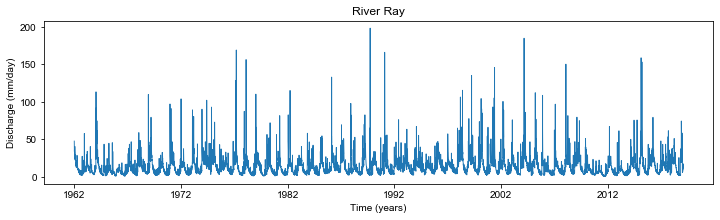

In [186]:
# Create data frame
raycsv = requests.get(
    'http://nrfaapps.ceh.ac.uk/nrfa/data/tsData/39017_gdf.csv?stn=39017&dt=gdf', allow_redirects=True)
openraycsv = 'zip/riverray.csv'
open(openraycsv, 'wb').write(raycsv.content)
dRay = pd.read_csv(openraycsv, low_memory=False)  # Discharge in m^3/s

# Scrub data
dRay = dRay.iloc[19:, :2]
dRay.rename(columns={'file': 'date',
                     'timestamp': 'q_mm_per_day'}, inplace=True)

# Unit conversion
dRay['q_mm_per_day'] = dCWT12['q_mm_per_day'].astype(float)
dRay['q_mm_per_day'] = dRay['q_mm_per_day'] * CFSfromCMS
dRay['q_mm_per_day'] = dRay['q_mm_per_day'] / areaFT2[10]
dRay['q_mm_per_day'] = dRay['q_mm_per_day'] * MMDAYfromFTS
dRay['q_mm_per_day'] = round(dRay['q_mm_per_day'], 3)
dRay.sort_values(by=['date'])
dRay = dRay.reset_index(drop=True)

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(dRay['date'], dRay['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='River Ray')
labels = ['1962', '1972', '1982', '1992', '2002', '2012']
ticks_to_use = dRay.index[::3650]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)
plt.show()

### Sagehen Creek

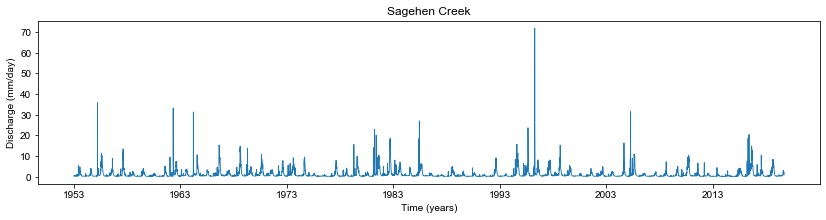

In [187]:
# Create data frame
dSagehen = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=10343500&referred_module=sw&period=&begin_date=' +
                       start[11] + '&end_date=' + stop[11], header=31, delim_whitespace=True)  # Discharge in cfs

# Scrub data
dSagehen.columns = ['usgs', 'site', 'date', 'q_mm_per_day', 'a']
dSagehen['q_mm_per_day'] = dSagehen['q_mm_per_day'].astype(float)
dSagehen['q_mm_per_day'] = dSagehen['q_mm_per_day'] / areaFT2[11]   
dSagehen['q_mm_per_day'] = dSagehen['q_mm_per_day'] * MMDAYfromFTS  
dSagehen = dSagehen.drop(columns=['usgs', 'site', 'a'])
dSagehen['q_mm_per_day'] = round(dSagehen['q_mm_per_day'], 3)
dSagehen.sort_values(by=['date'])
dSagehen = dSagehen.reset_index(drop=True)

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(dSagehen['date'], dSagehen['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='Sagehen Creek')
labels = ['1953', '1963', '1973', '1983', '1993', '2003', '2013']
ticks_to_use = dSagehen.index[::3650]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)
plt.show()

### Upper Studibach

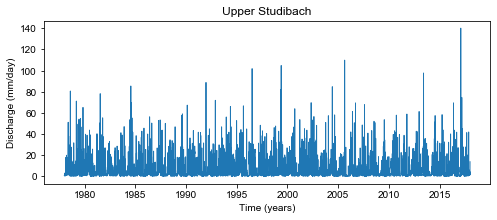

In [188]:
# Create data frame
dStud = pd.read_excel('https://www.envidat.ch/dataset/4de5d4cd-f265-48b9-98a1-290d6f78fb23/resource/0216a1f8-97b9-4668-b765-621831a63885/download/runoff_daily-mean_alptal_1968-2017.xlsx',
                      sheet_name='Erlenbach')  # Discharge in L/s

# Scrub data
dStud.rename(columns={dStud.columns[0]: 'date',
                      dStud.columns[1]: 'q_mm_per_day'}, inplace=True)
dStud = dStud[7:]
dStud = dStud.drop(
    columns={dStud.columns[2], dStud.columns[3], dStud.columns[4]})
dStud['date'] = dStud['date'].replace(' 00:00:00', '')

# Unit conversion
dStud['q_mm_per_day'] = dStud['q_mm_per_day'].astype(float)
dStud['q_mm_per_day'] = dStud['q_mm_per_day'] * CMSfromLS # Multiply discharge in L/s by CMSfromLS to get cms
dStud['q_mm_per_day'] = dStud['q_mm_per_day'] * CFSfromCMS 
dStud['q_mm_per_day'] = dStud['q_mm_per_day'] / 0.7 # Uses Erlenbach (proxy) watershed area
dStud['q_mm_per_day'] = dStud['q_mm_per_day'] * MMDAYfromFTS # Multiply discharge in ft/s by MMDAYfromFTS to get mm/day
dStud['q_mm_per_day'] = round(dStud['q_mm_per_day'], 3)
dStud.sort_values(by=['date'])
dStud = dStud.reset_index(drop=True)

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(dStud['date'], dStud['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='Upper Studibach')
labels = ['1978', '1988', '1998', '2008']
ticks_to_use = dStud.index[::3650]
plt.show()

### Yellow Barn

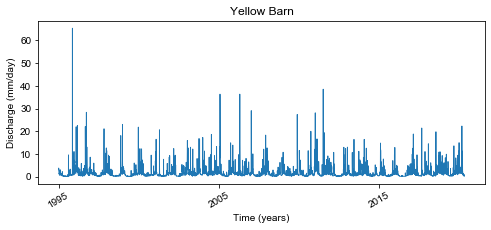

In [189]:
# Create data frame
dYellow = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=04233300&referred_module=sw&period=&begin_date=' +
                      start[13]+'&end_date='+stop[13], header=28, delim_whitespace=True)  # Discharge in cfs
dYellow = dYellow.drop([0])

# Scrub data
dYellow.columns = ['usgs', 'site', 'date', 'q_mm_per_day', 'a']

# Unit conversion
dYellow['q_mm_per_day'] = dYellow['q_mm_per_day'].astype(float)
dYellow['q_mm_per_day'] = dYellow['q_mm_per_day'] / (101.01 * FT2fromkm2)  # Uses Six Mile Creek (proxy) watershed area
dYellow['q_mm_per_day'] = dYellow['q_mm_per_day'] * MMDAYfromFTS
dYellow = dYellow.drop(columns=['usgs', 'site', 'a'])
dYellow['q_mm_per_day'] = round(dYellow['q_mm_per_day'], 3)
dYellow.sort_values(by=['date'])
dYellow = dYellow.reset_index(drop=True)

# Plot data
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(dYellow['date'], dYellow['q_mm_per_day'], linewidth=0.9)
ax.set(xlabel='Time (years)', ylabel='Discharge (mm/day)', title='Yellow Barn')
labels = ['1995', '2005', '2015']
ticks_to_use = dYellow.index[::3650]
ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels, rotation=30)
plt.show()

## Köppen climate zone classification

In [196]:
# Köppen climate zone classification

# Get watershed metadata
dMeta = pd.read_csv(
    'https://www.hydroshare.org/resource/37a7544cc3b944e88a8754bd6c1b8eb1/data/contents/ws_metadata.csv')

# Get Köppen Classification System per Chen and Chen, http://hanschen.org/koppen/#data
dKoppen = pd.read_csv(
    'zip/koppensys/koppen_30year_1901-2010.tsv', delimiter="\t")

# Scrub data
dKoppen.drop(dKoppen.columns[[2, 3, 4, 5, 6, 7, 8, 9]], axis=1, inplace=True)

# Print table header
print('{:<16}'.format('Watershed'), 'Köppen Class')

# Find closest Köppen coordinates
kLat = list()
kLon = list()

for i in range(len(dMeta)):
    # Get gauge station coordinates
    lat = dMeta['gauge_lat_decdeg'][i]
    lon = dMeta['gauge_lon_decdeg'][i]
    kLat.append(lat)
    kLon.append(lon)

    # Get fractional and whole portions of float
    fracLat, wholeLat = math.modf(float(kLat[i]))
    fracLon, wholeLon = math.modf(float(kLon[i]))

    # Create Köppen classification latitude
    if fracLat == 0.25 or fracLat == 0.75:
        break
    else:
        if fracLat >= 0 and fracLat < 0.5:
            kLat[i] = wholeLat + 0.25
        else:
            kLat[i] = wholeLat + 0.75

    # Create Köppen classification longitude
    if fracLon == 0.25 or fracLon == 0.75:
        break
    else:
        if wholeLon < 0:
            if fracLon <= 0 and fracLon > -0.5:
                kLon[i] = wholeLon - 0.25
            else:
                kLon[i] = wholeLon - 0.75
        else:
            if fracLon >= 0 and fracLon < 0.5:
                kLon[i] = wholeLon + 0.25
            else:
                kLon[i] = wholeLon + 0.75

# Get Köppen class
for i in range(len(dKoppen)):
    if dKoppen['longitude'][i] == kLon[0]:  # Bull Creek
        if dKoppen['latitude'][i] == kLat[0]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [0]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[1]:  # Caspar Creek
        if dKoppen['latitude'][i] == kLat[1]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [1]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[2]:  # CWT12
        if dKoppen['latitude'][i] == kLat[2]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [2]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[3]:  # Duke
        if dKoppen['latitude'][i] == kLat[3]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [3]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[4]:  # Elder Creek
        if dKoppen['latitude'][i] == kLat[4]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [4]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[5]:  # FNW37
        if dKoppen['latitude'][i] == kLat[5]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [5]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[6]:  # HB13
        if dKoppen['latitude'][i] == kLat[6]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [6]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[7]:  # HB42
        if dKoppen['latitude'][i] == kLat[7]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [7]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[8]:  # Pioneer Creek
        if dKoppen['latitude'][i] == kLat[8]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [8]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[9]:  # Providence Creek
        if dKoppen['latitude'][i] == kLat[9]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [9]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[10]:  # River Ray
        if dKoppen['latitude'][i] == kLat[10]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [10]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[11]:  # Sagehen Creek
        if dKoppen['latitude'][i] == kLat[11]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [11]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[12]:  # Upper Studibach
        if dKoppen['latitude'][i] == kLat[12]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [12]), dKoppen['p1981_2010'][i])

    if dKoppen['longitude'][i] == kLon[13]:  # Yellow Barn
        if dKoppen['latitude'][i] == kLat[13]:
            print('{:<16}'.format(dMeta['ws_name']
                                  [13]), dKoppen['p1981_2010'][i])

Watershed        Köppen Class
Elder Creek      Csb
Caspar Creek     Csb
Sagehen Creek    Dsb
Providence       Csb
Bull Creek       Csa
Pioneer Creek    Dfb
CWT12            Cfb
FNW37            Cfb
Duke Forest      Cfa
Yellow Barn      Dfb
HB13             Dfb
HB42             Dfb
River Ray        Cfb
Upper Studibach  Cfb


## Plot watersheds by climate zone

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


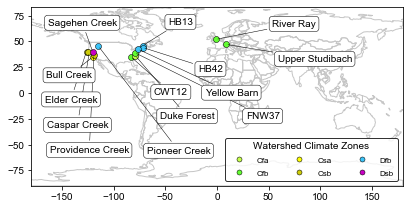

In [191]:
# Create data frames
dMeta = pd.read_csv(
    'https://www.hydroshare.org/resource/37a7544cc3b944e88a8754bd6c1b8eb1/data/contents/ws_metadata.csv')
d = pd.DataFrame(
    {'Watershed': ['Bull Creek', 'Caspar Creek', 'CWT12', 'Duke Forest', 'Elder Creek', 'FNW37', 'HB13', 'HB42', 'Pioneer Creek', 'Providence', 'River Ray', 'Sagehen Creek', 'Upper Studibach', 'Yellow Barn'],
     'PointColour': ['#fcfe04', '#cecc08', '#63fd32', '#c5fe4b', '#cecc08', '#63fd32', '#3cc4f8', '#3cc4f8', '#3cc4f8', '#cecc08', '#63fd32', '#c900c4', '#63fd32', '#3cc4f8'],
     'Label': ['Csa', 'Csb', 'Cfb', 'Cfa', 'Csb', 'Cfb', 'Dfb', 'Dfb', 'Dfb', 'Csb', 'Cfb', 'Dsb', 'Cfb', 'Dfb'],
     'Latitude': [dMeta['gauge_lat_decdeg'].loc[0]-2, dMeta['gauge_lat_decdeg'].loc[1], dMeta['gauge_lat_decdeg'].loc[2], dMeta['gauge_lat_decdeg'].loc[3], dMeta['gauge_lat_decdeg'].loc[4], dMeta['gauge_lat_decdeg'].loc[5], dMeta['gauge_lat_decdeg'].loc[6]+2, dMeta['gauge_lat_decdeg'].loc[7], dMeta['gauge_lat_decdeg'].loc[8], dMeta['gauge_lat_decdeg'].loc[9], dMeta['gauge_lat_decdeg'].loc[10], dMeta['gauge_lat_decdeg'].loc[11], dMeta['gauge_lat_decdeg'].loc[12], dMeta['gauge_lat_decdeg'].loc[13]],
     'Longitude': [dMeta['gauge_lon_decdeg'].loc[0]-1, dMeta['gauge_lon_decdeg'].loc[1]-2, dMeta['gauge_lon_decdeg'].loc[2], dMeta['gauge_lon_decdeg'].loc[3], dMeta['gauge_lon_decdeg'].loc[4]-1, dMeta['gauge_lon_decdeg'].loc[5], dMeta['gauge_lon_decdeg'].loc[6], dMeta['gauge_lon_decdeg'].loc[7], dMeta['gauge_lon_decdeg'].loc[8], dMeta['gauge_lon_decdeg'].loc[9], dMeta['gauge_lon_decdeg'].loc[10], dMeta['gauge_lon_decdeg'].loc[11], dMeta['gauge_lon_decdeg'].loc[12], dMeta['gauge_lon_decdeg'].loc[13]]})
gdf = gpd.GeoDataFrame(d, geometry=gpd.points_from_xy(
    d['Longitude'], d['Latitude']))

# Set up plot axes
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='', edgecolor='#c6c6c6', figsize=(6, 3), markersize=8, linewidth=1)
ax.margins(x=0, y=0)

i = 0

# Coordinates for plot
for x, y in zip(d.Longitude, d.Latitude):
    ax.scatter(x, y, c=d['PointColour'][i], edgecolors='black', linewidths=0.5)
    i = i + 1
plt.annotate('Providence Creek', xy=(-119.21, 37.06), xytext=(35, -100), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('Caspar Creek', xy=(-123.73, 39.34), xytext=(19, -77), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('Pioneer Creek', xy=(-114.842, 45.25), xytext=(112, -109), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('Duke Forest', xy=(-78.98, 36.02), xytext=(79, -65), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('CWT12', xy=(-83.44, 35.05), xytext=(57, -40), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('Elder Creek', xy=(-123.64-3, 39.73), xytext=(11, -52), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('Bull Creek', xy=(-119.06-1, 36.97-2), xytext=(-1, -23), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('FNW37', xy=(-79.69, 39.05), xytext=(145, -68), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('HB13', xy=(-71.74, 43.95+2), xytext=(50, 19), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('Yellow Barn', xy=(-76.44, 42.40), xytext=(120, -48), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('HB42', xy=(-71.72, 43.96), xytext=(80, -26), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('River Ray', xy=(-1.01, 51.88), xytext=(100, 11), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('Sagehen Creek', xy=(-120.24, 39.43), xytext=(24, 25), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))
plt.annotate('Upper Studibach', xy=(8.73, 47.04), xytext=(126, -19), textcoords='offset points', ha='right', va='bottom', bbox=dict(
    boxstyle='round,pad=0.3', fc='#ffffff', edgecolor='black', lw=0.5), arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0', lw=0.5))

plt.tight_layout()

# Create legend
Cfa_patch = Line2D([0], [0], marker='o', color='w', mec='k', mew=0.5, label='Cfa', mfc='#c5fe4b', ms=5)
Cfb_patch = Line2D([0], [0], marker='o', color='w', mec='k', mew=0.5, label='Cfb', mfc='#63fd32', ms=5)
Csa_patch = Line2D([0], [0], marker='o', color='w', mec='k', mew=0.5, label='Csa', mfc='#fcfe04', ms=5)
Csb_patch = Line2D([0], [0], marker='o', color='w', mec='k', mew=0.5, label='Csb', mfc='#cecc08', ms=5)
Dfb_patch = Line2D([0], [0], marker='o', color='w', mec='k', mew=0.5, label='Dfb', mfc='#3cc4f8', ms=5)
Dsb_patch = Line2D([0], [0], marker='o', color='w', mec='k', mew=0.5, label='Dsb', mfc='#c900c4', ms=5)
plt.legend(handles=[Cfa_patch, Cfb_patch, Csa_patch, Csb_patch, Dfb_patch, Dsb_patch],
           loc='lower right', ncol=3, title='Watershed Climate Zones', edgecolor='black')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='8')

# Show plot
# plt.savefig('mapgrpbycli.eps', format='eps', dpi=300) # Save print resolution image
plt.show()

## Find alpha and beta +- standard deviation
Based on code by Dana Lapides

In [192]:
# Access watershed metadata
dMeta = pd.read_csv(
    'https://www.hydroshare.org/resource/37a7544cc3b944e88a8754bd6c1b8eb1/data/contents/ws_metadata.csv')

# Create arrays
alpha = []
beta = []
survey = []

# Print results table header
print('{:<18}'.format('Watershed') + '{:<19}'.format('alpha') +
      '{:<0}'.format('beta'))

# Get data and
for i in range(len(dMeta)):

    # Import hydrograph data
    survey = pd.read_csv('surveys/surveys_' +
                         dMeta['ws_name'][i].replace(' ', '').lower() + '.csv')
    Q = survey['q_mm_per_day']
    L = survey['dd_km_per_km2']

    # Find alpha and beta
    def model(Q, alpha, beta):
        """Return the wetted channel extent (L) as drainage density."""
        return alpha * Q ** beta

    # Find optimal parameter values and estimated parameter covariance
    popt, pcov = scipy.optimize.curve_fit(model, Q, L)

    # retrieve parameter values
    alpha = round(popt[0], 4), '+/-', round(pcov[0, 0]**0.5, 4)
    beta = round(popt[1], 4), '+/-', round(pcov[1, 1]**0.5, 4)

    # Print results table body rows
    print(str('{:<18}'.format(dMeta['ws_name'][i]) +
              '{:<25}'.format(str(alpha)) + '{:<25}'.format(str(beta))).replace('(', '').replace(')', '').replace(',', '').replace('\'', ''))

Watershed         alpha              beta
Bull Creek        2.9472 +/- 0.0789  0.187 +/- 0.0195   
Caspar Creek      1.271 +/- 0.0866   0.3125 +/- 0.0372  
CWT12             4.7027 +/- 0.1393  0.0753 +/- 0.0184  
Duke Forest       3.7912 +/- 0.1824  0.1781 +/- 0.0152  
Elder Creek       3.3695 +/- 0.4457  0.1806 +/- 0.0374  
FNW37             1.7965 +/- 0.0634  0.1721 +/- 0.0239  
HB13              7.6794 +/- 0.4451  0.1393 +/- 0.0307  
HB42              5.5818 +/- 0.185   0.1992 +/- 0.0256  
Pioneer Creek     0.8318 +/- 0.0133  0.1978 +/- 0.0288  
Providence        1.7853 +/- 0.1134  0.3882 +/- 0.0639  
River Ray         2.399 +/- 0.0935   0.1495 +/- 0.0157  
Sagehen Creek     1.1197 +/- 0.0735  0.3202 +/- 0.0757  
Upper Studibach   6.1268 +/- 1.671   0.3119 +/- 0.1418  
Yellow Barn       5.4044 +/- 0.1585  0.1041 +/- 0.0314  


## Mean and standard deviation for Q and L
Based on code by Dana Lapides

In [193]:
# Create data frame
dMeta = pd.read_csv('https://www.hydroshare.org/resource/37a7544cc3b944e88a8754bd6c1b8eb1/data/contents/ws_metadata.csv')
dMeta = dMeta.drop(['ws_name_sub', 'gauge_id', 'gauge_name', 'gauge_lat_decdeg', 'gauge_lon_decdeg', 'q_url', 'gauge_elev_m', 'q_start', 'q_stop', 'ws_elev_avg_m', 'ws_soil', 'ws_bedrock', 'ws_climate', 'ws_precip_mm_per_yr'], axis=1)
dMeta = dMeta.reset_index()

Q_series = ['https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_bullcreek.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_casparcreek.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_cwt12.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_dukeforest.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_dukeforest.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_fnw37.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_hb13.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_hb42.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_pioneercreek.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_providence.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_riverray.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_sagehencreek.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_upperstudibach.csv',
            'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_yellowbarn.csv']

# Print results table header
print('{:<16}'.format('Watershed'),
      '{:<10}'.format('Q_mean'),
      '{:<10}'.format('Q_std'),
      '{:<10}'.format('L_mean'),
      '{:<10}'.format('L_std'))

qMean = list()
lMean = list()
qStd = list()
lStd = list()

for i in range(len(dMeta)):
    data = pd.read_csv(Q_series[i])
    alpha = dMeta['alpha_units_vary'][i]
    beta = dMeta['beta'][i]
    Q = data['q_mm_per_day']
    L = alpha * Q ** beta
    qMean.append(np.mean(Q)) 
    lMean.append(np.mean(L / dMeta['ws_area_km2'][i])) # L as drainage density in km/km^2 
    qStd.append(np.std(Q))  
    lStd.append(np.std(L / dMeta['ws_area_km2'][i])) # Standard deviation for L as drainage density in km/km^2 

    # Print results table body rows
    print('{:<16}'.format(dMeta['ws_name'][i]),
          '{:<10}'.format(str(round(qMean[i], 4))),
          '{:<10}'.format(str(round(qStd[i], 4))),
          '{:<10}'.format(str(round(lMean[i], 4))),
          '{:<10}'.format(str(round(lStd[i], 4))))

Watershed        Q_mean     Q_std      L_mean     L_std     
Bull Creek       1.7878     3.5187     0.7879     0.2084    
Caspar Creek     1.3609     4.3229     0.1156     0.0714    
CWT12            2.725      2.5469     39.6182    4.5599    
Duke Forest      1.1791     5.3538     65.207     54.6525   
Elder Creek      1.1791     5.3538     0.1136     0.0962    
FNW37            1.7448     3.1404     4.4371     1.6947    
HB13             2.5776     5.1343     57.4087    13.9366   
HB42             2.3926     4.8902     13.1899    4.1828    
Pioneer Creek    0.2771     0.208      0.0392     0.0068    
Providence       0.9351     1.6973     0.3574     0.1884    
River Ray        0.4412     1.2623     0.0794     0.0437    
Sagehen Creek    1.0692     1.9752     0.0354     0.0145    
Upper Studibach  4.813      7.8766     11.8245    5.2543    
Yellow Barn      1.5067     2.3166     0.053      0.0058    


## Coefficient of variation for Q and L
Based on code by Dana Lapides

In [223]:
# Coefficient of variation for Q and L
# Based on code by Dana Lapides

# CVL formula based on work of Gianluca Botter, derived by David Dralle
def botter_CVL(beta, CVQ):
    num = math.gamma(1./CVQ**2)*math.gamma(2.*beta+1. /
                                           CVQ**2.)-math.gamma(beta+1/CVQ**2)**2
    denom = math.gamma(beta+1/CVQ**2)
    return (num**0.5/denom)

# Remove NaN values from hydrograph
def remove_nan(hydrograph):
    hydrorange = []
    hydrograph.index.drop_duplicates(keep='first')
    for j in range(len(hydrograph)):
        if math.isnan(hydrograph['q_mm_per_day'][j]):
            hydrograph[(hydrograph['q_mm_per_day'] != np.nan)]
        else:
            hydrorange = hydrorange + [j]
    hydrograph = hydrograph.iloc[hydrorange, :]
    return hydrograph

# Create data frame for watershed metadata 
dMeta = pd.read_csv('https://www.hydroshare.org/resource/37a7544cc3b944e88a8754bd6c1b8eb1/data/contents/ws_metadata.csv')
dMeta = dMeta.reset_index()

# Print results table header
print('{:<18}'.format('Watershed') + '{:<10}'.format('CVQ') +
      '{:<10}'.format('CVL_emp') + '{:<10}'.format('CVL_botter'))

# Create arrays
CVQ = []
CVL_emp = []
CVL_botter = []
hydroL = list()

# Find CVQ, CVL_emp, and CVL_botter
for i in range(len(dMeta)):

    # Import hydrograph data
    hydrograph = pd.read_csv(
        'https://www.hydroshare.org/resource/1182147d58724a2a84dc3a382636d35e/data/contents/q_' + dMeta['ws_name'][i].replace(' ', '').lower() + '.csv')

    # Set to date index
    hydrograph = hydrograph.set_index('date')
    hydrograph.index = pd.to_datetime(hydrograph.index)

    # Remove NaN values that cause error in CV calculation
    hydrograph['q_mm_per_day'] = pd.to_numeric(
        hydrograph['q_mm_per_day'], errors='coerce')
    hydrograph = remove_nan(hydrograph)

    # Calculate L timeseries
    alpha = dMeta['alpha_units_vary'][i]
    beta = dMeta['beta'][i]
    
    for i in range(len(hydrograph)):
        hydroLItem = alpha*hydrograph['q_mm_per_day'][i]**beta
        hydroL.append(hydroLItem)

    # Calculate coefficients of variation
    CVQ = CVQ + [np.std(hydrograph['q_mm_per_day']) / np.mean(hydrograph['q_mm_per_day'])] # CVQ
    CVL_emp = CVL_emp + [np.std(hydroL) / np.mean(hydroL)] # CVL empirical
    CVL_botter = CVL_botter + [botter_CVL(beta, CVQ[-1])] # CVL from David Dralle's formula

# Print results table body
for i in range(len(dMeta)):
    print('{:<18}'.format(dMeta['ws_name'][i]) + '{:<10}'.format(str(
        round(CVQ[i], 4))) + '{:<10}'.format(str(round(CVL_emp[i], 4))) + '{:<10}'.format(str(round(CVL_botter[i], 4))))

Watershed         CVQ       CVL_emp   CVL_botter
Bull Creek        1.9682    0.2645    0.5069    
Caspar Creek      3.1765    0.6471    1.2691    
CWT12             0.9346    0.3154    0.084     
Duke Forest       4.5404    0.3259    1.3115    
Elder Creek       2.2946    0.3411    0.6083    
FNW37             1.7998    0.4942    0.4242    
HB13              1.9919    0.5798    0.4102    
HB42              2.0439    0.5361    0.5574    
Pioneer Creek     0.7506    0.5577    0.1615    
Providence        1.8152    0.5681    0.8058    
River Ray         2.8612    0.6331    0.6874    
Sagehen Creek     1.8475    0.72      0.7081    
Upper Studibach   1.6365    0.7532    0.6039    
Yellow Barn       1.5375    0.7276    0.2256    
